### Objective: Design and train a deep learning model that classifies human emotions using both

### Loading the Dataset from kaggle
Lets load the dataset from kaggle and import some of the libraries we will need (I have also imported some modules later as needed)

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)
output_dir = r"D:\IITH\programming for AI\CNN-RNN\spectograms"
input_dir = rf"{output_dir}"

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Converting audio into spectorgram
Here we will convert .wav file into spectogram using librosa

In [ ]:
import librosa
import librosa.display

def audio_to_mel_spectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

base_dir = rf"{path}"
output_dir = r"D:\IITH\programming for AI\CNN-RNN\spectograms"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)

    if os.path.isdir(actor_path):
        output_actor_dir = os.path.join(output_dir, actor_folder) #respective output folder for each actor
        if not os.path.exists(output_actor_dir):
            os.makedirs(output_actor_dir)

        for file_name in os.listdir(actor_path):
            if file_name.endswith('.wav'): #checking for .wav files
                input_audio_path = os.path.join(actor_path, file_name)
                output_image_path = os.path.join(output_actor_dir, file_name.replace('.wav', '.png'))

                audio_to_mel_spectrogram(input_audio_path, output_image_path)



### Preprocessing of Data:

### Extracting
This code processes a dataset of images to extract file paths and corresponding emotion labels, then encodes the labels as integers.

1. **Emotion Mapping**: Defines a dictionary `emotion_map` that maps emotion codes (e.g., '01') to emotion labels (e.g., 'neutral').
2. **File Traversal**: Iterates through folders in `input_dir`, each representing an actor, and checks for `.png` image files.
3. **Label Extraction**: For each image, splits the filename by '-' to extract the emotion code (third part), maps it to an emotion label using `emotion_map`, and stores the image path and label if valid.
4. **Label Encoding**: Uses `LabelEncoder` from `sklearn.preprocessing` to convert emotion labels into integer IDs for machine learning tasks.
5. **Output**: `image_paths` contains all valid image file paths, `labels` contains corresponding emotion labels, and `label_ids` contains the encoded integer labels.

In [ ]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

image_paths = []
labels = []

for actor_folder in os.listdir(input_dir):
    actor_path = os.path.join(input_dir, actor_folder)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith('.png'): #just to make sure we are checking for .png files
                full_path = os.path.join(actor_path, file_name)
                parts = file_name.split('-')

                emotion_code = parts[2]
                emotion_label = emotion_map.get(emotion_code)
                if emotion_label:
                    image_paths.append(full_path)
                    labels.append(emotion_label)

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_ids = le.fit_transform(labels)
label_ids

array([5, 5, 5, ..., 7, 7, 7], shape=(1440,))

### Splitting into Train, Validation and Test Sets
We will split the data into 70-15-15 for train, valid and test respectively

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, label_ids, test_size=0.15, stratify=label_ids, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1008, Val: 216, Test: 216


### Saving into CSV

In [ ]:
def savesplit_to_csv(paths, labels, filename):
    df = pd.DataFrame({'path': paths, 'label': labels})
    df.to_csv(filename, index=False)

savesplit_to_csv(X_train, y_train, "train.csv")
savesplit_to_csv(X_val, y_val, "val.csv")
savesplit_to_csv(X_test, y_test, "test.csv")

### Visualizing some images

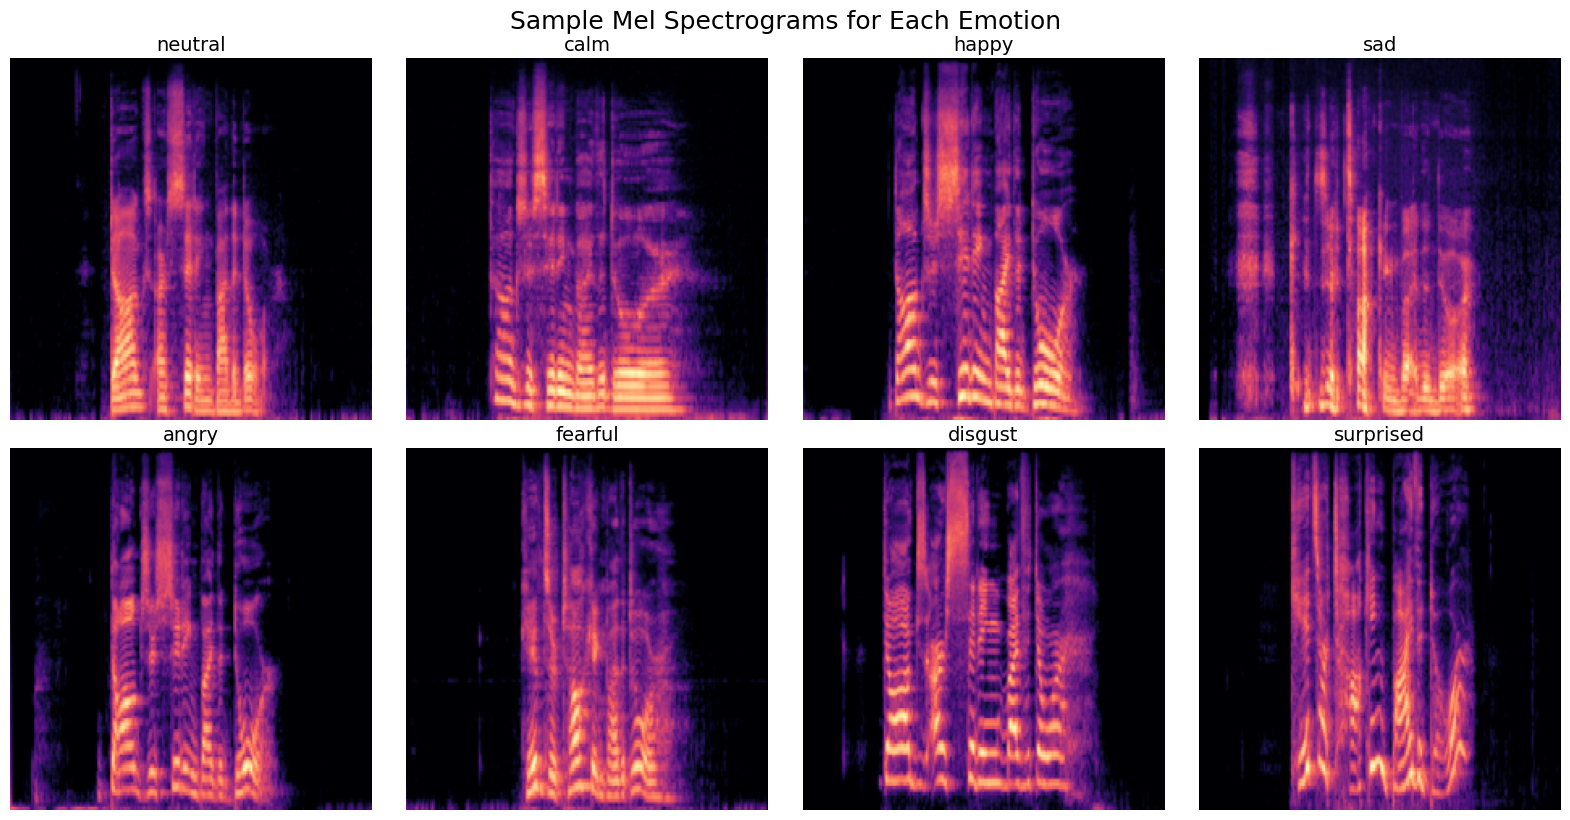

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, emotion in enumerate(emotion_map.values()):
    emotion_id = np.where(le.classes_ == emotion)[0][0]

    example_indices = np.where(y_train == emotion_id)[0]
    img_path = X_train[example_indices[0]]
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"{emotion}", fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Sample Mel Spectrograms for Each Emotion", fontsize=18, y=1.02)
plt.show()

### Custom Dataset class
markdown

Copy
This code defines a custom PyTorch dataset and data loaders for spectrogram image data, with transformations and class-balanced sampling.

1. **SpectrogramDataset Class**:
   - Loads data from a CSV file containing image paths and labels.
   - Implements `__len__` to return dataset size and `__getitem__` to load an image, convert it to RGB, apply transformations, and return the image and label.

2. **Transformations**:
   - `spec_augment`: Applies frequency and time masking (parameters 30 and 40) for data augmentation.
   - `train_transform`: Converts images to grayscale, applies `spec_augment`, converts to tensor, and normalizes with mean=0.45, std=0.20.
   - `val_test_transform`: Same as `train_transform` but without `spec_augment`.

3. **Datasets**:
   - Creates `train_dataset`, `val_dataset`, and `test_dataset` from respective CSV files (`train.csv`, `val.csv`, `test.csv`) with appropriate transforms.

4. **Weighted Sampling**:
   - Computes class weights inversely proportional to class frequencies in `train_labels`.
   - Uses `WeightedRandomSampler` to balance classes in training by oversampling underrepresented classes.

5. **Data Loaders**:
   - `train_loader`: Uses `WeightedRandomSampler` or `shuffle=True` (note: code defines `train_loader` twice; second definition with `shuffle=True` overrides sampler).
   - `val_loader` and `test_loader`: Batch size=32, no shuffling.

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = int(self.data.iloc[idx]['label'])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torchaudio.transforms as T

spec_augment = nn.Sequential(
    T.FrequencyMasking(freq_mask_param=30),
    T.TimeMasking(time_mask_param=40),
)

train_mean, train_std = 0.45, 0.20

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: spec_augment(x)),
    transforms.Normalize([train_mean], [train_std]),
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([train_mean], [train_std]),
])

train_dataset = SpectrogramDataset("train.csv", transform=train_transform)
val_dataset   = SpectrogramDataset("val.csv",   transform=val_test_transform)
test_dataset  = SpectrogramDataset("test.csv",  transform=val_test_transform)
BATCH_SIZE = 32

from torch.utils.data import WeightedRandomSampler

train_labels = train_dataset.data['label'].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=sampler)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Visualization

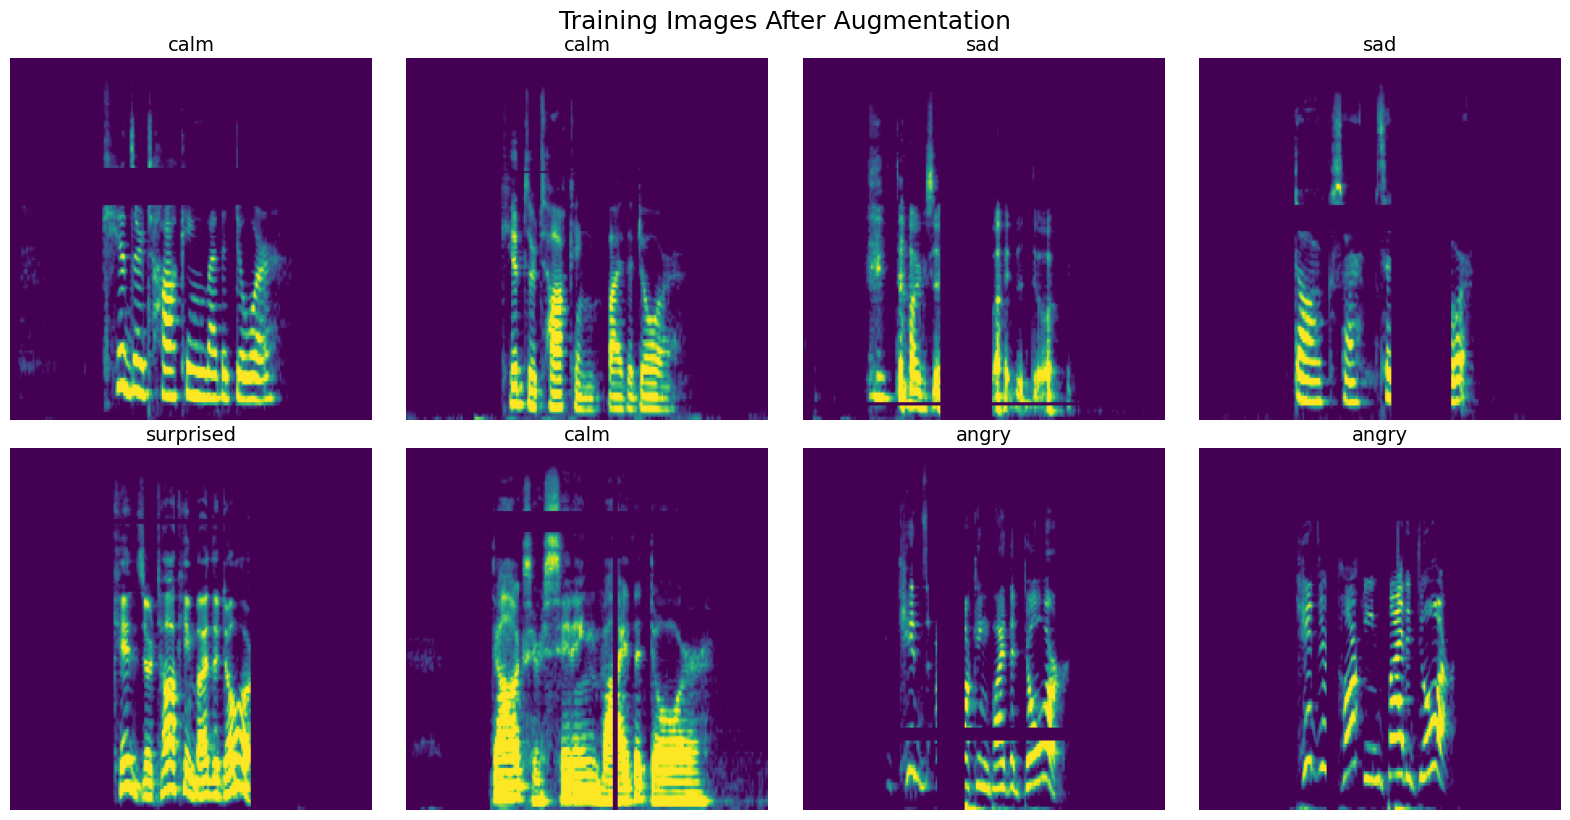

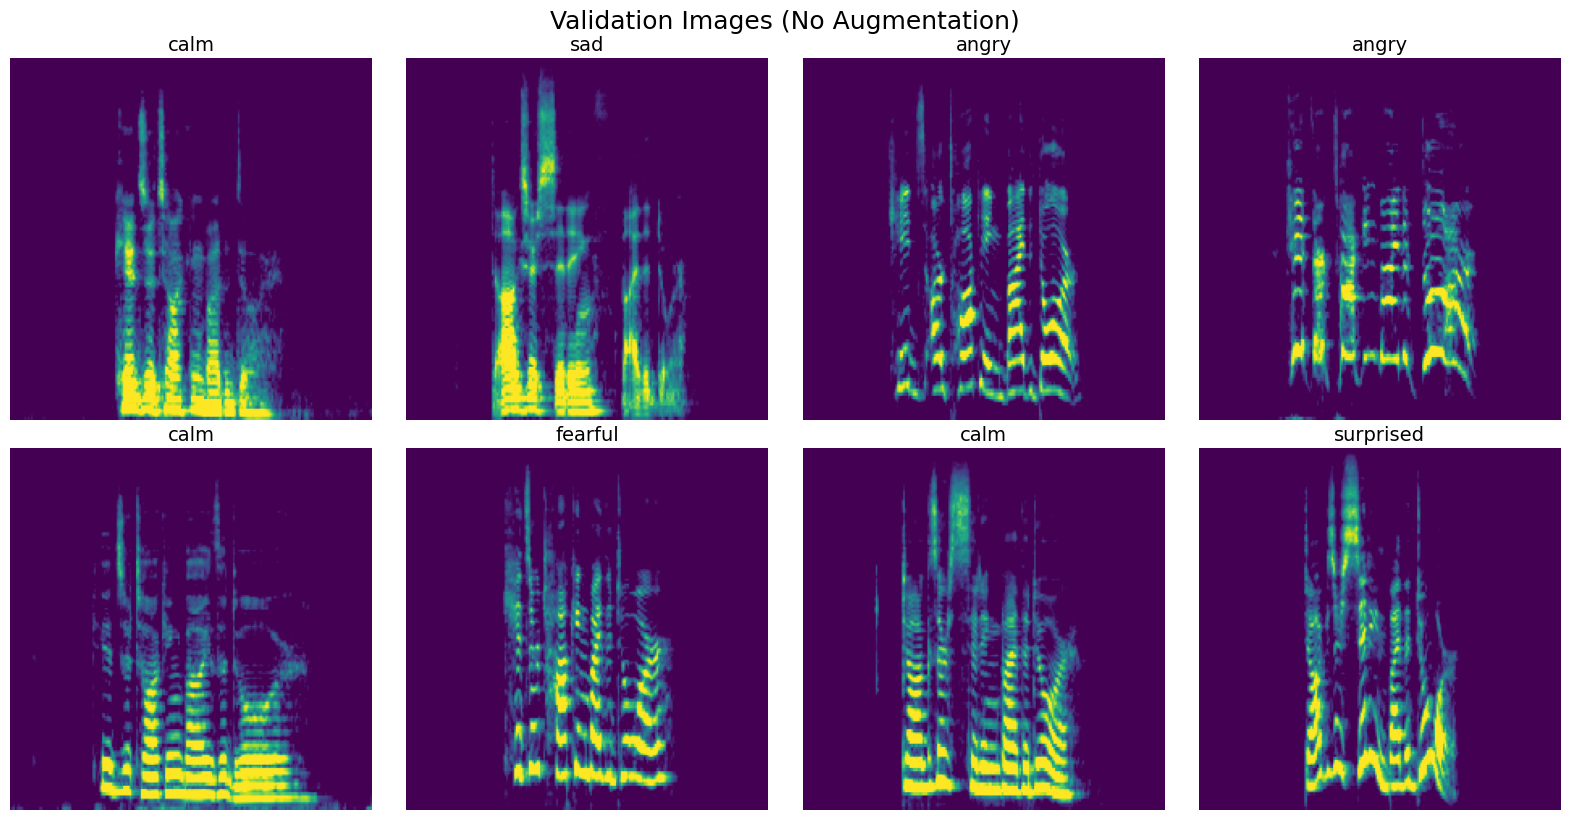

In [ ]:
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor.permute(1, 2, 0).cpu().numpy().clip(0, 1)

train_images, train_labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img = denormalize(train_images[i])
    label_idx = train_labels[i].item()
    emotion = le.classes_[label_idx]

    axes[i].imshow(img)
    axes[i].set_title(f"{emotion}", fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Training Images After Augmentation", fontsize=18, y=1.02)
plt.show()

val_images, val_labels = next(iter(val_loader))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img = denormalize(val_images[i])
    label_idx = val_labels[i].item()
    emotion = le.classes_[label_idx]

    axes[i].imshow(img)
    axes[i].set_title(f"{emotion}", fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Validation Images (No Augmentation)", fontsize=18, y=1.02)
plt.show()

1. **SimpleCNN Class**:
   - Inherits from `nn.Module` with a default of 8 output classes.
   - **Architecture**:
     - Four convolutional layers (`conv1` to `conv4`) with increasing channels (1→64, 64→128, 128→256, 256→512), 3x3 kernels, and padding=1.
     - Each conv layer is followed by batch normalization (`bn1` to `bn4`) for stable training.
     - Max pooling (`pool`, 2x2) after each conv layer reduces spatial dimensions.
     - Adaptive average pooling (`avgpool`) outputs 1x1 feature maps.
     - Dropout (0.5) prevents overfitting.
     - Fully connected layer (`fc`) maps 512 features to `num_classes` outputs.

2. **Forward Method**:
   - Processes input through conv → batch norm → ReLU → pooling for each of the four layers.
   - Applies adaptive pooling, flattens the output, adds dropout, and passes through the final linear layer.
   - Returns classification logits.

3. **Extract Features Method**:
   - Similar to `forward` but stops before the final linear layer.
   - Returns flattened feature vectors (512-dimensional) for tasks like feature extraction or tran

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SimpleCNN, self).__init__()
        # Update dimensions to match the saved model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Changed from 32 to 64
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)  # Changed from 256 to 512

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def extract_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = SimpleCNN(num_classes=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

### Defining function to evaluate and train the model

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Acc: {(train_acc)*100:.4f}% | Val Loss: {val_loss:.4f} | Val Acc: {(val_acc)*100:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20)

Epoch 1/20 - Train Loss: 1.9969 | Acc: 22.2222% | Val Loss: 2.0654 | Val Acc: 16.2037
Epoch 2/20 - Train Loss: 1.8708 | Acc: 26.6865% | Val Loss: 1.8492 | Val Acc: 30.5556
Epoch 3/20 - Train Loss: 1.7619 | Acc: 33.2341% | Val Loss: 1.7173 | Val Acc: 41.6667
Epoch 4/20 - Train Loss: 1.7136 | Acc: 34.3254% | Val Loss: 1.7073 | Val Acc: 33.7963
Epoch 5/20 - Train Loss: 1.6625 | Acc: 37.7976% | Val Loss: 2.1229 | Val Acc: 16.6667
Epoch 6/20 - Train Loss: 1.5431 | Acc: 42.5595% | Val Loss: 2.6259 | Val Acc: 24.5370
Epoch 7/20 - Train Loss: 1.5777 | Acc: 39.3849% | Val Loss: 4.4139 | Val Acc: 14.3519
Epoch 8/20 - Train Loss: 1.4995 | Acc: 42.5595% | Val Loss: 1.7640 | Val Acc: 34.2593
Epoch 9/20 - Train Loss: 1.4450 | Acc: 44.5437% | Val Loss: 1.6646 | Val Acc: 43.5185
Epoch 10/20 - Train Loss: 1.3883 | Acc: 48.9087% | Val Loss: 1.5619 | Val Acc: 38.8889
Epoch 11/20 - Train Loss: 1.3885 | Acc: 49.0079% | Val Loss: 1.7358 | Val Acc: 37.0370
Epoch 12/20 - Train Loss: 1.3702 | Acc: 48.8095% | V

### Plotting confusion matrix to check if any class has higher inaccuracy

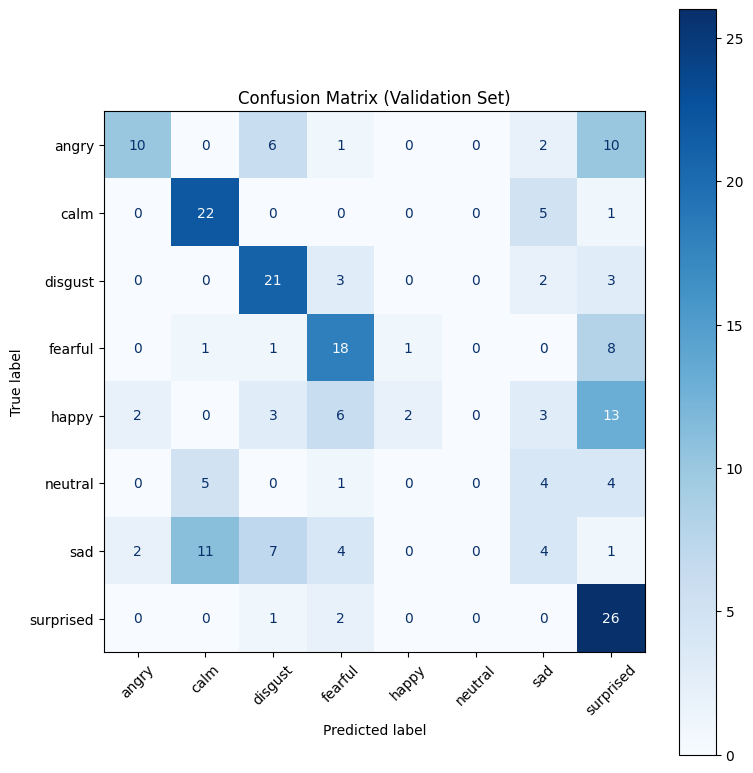

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

### Classification report for accuracy, precision, recall and f-1score

In [ ]:
from sklearn.metrics import classification_report

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=le.classes_))

Test Loss: 1.3784 | Test Acc: 45.83%

Classification Report:
               precision    recall  f1-score   support

       angry       0.62      0.36      0.45        28
        calm       0.51      0.90      0.65        29
     disgust       0.47      0.55      0.51        29
     fearful       0.50      0.48      0.49        29
       happy       0.75      0.10      0.18        29
     neutral       0.00      0.00      0.00        14
         sad       0.29      0.14      0.19        29
   surprised       0.38      0.90      0.53        29

    accuracy                           0.46       216
   macro avg       0.44      0.43      0.38       216
weighted avg       0.47      0.46      0.40       216



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Audio Processing

1. **Data Preparation**:
   - Defines `emotion_sentences`, a dictionary with 8 emotions, each with 4 descriptive sentences.
   - Flattens sentences and labels into lists for processing.

In [52]:
import re
from torch.nn.utils.rnn import pad_sequence
emotion_sentences = {
    'neutral': [
        "He looked at the scene without a change in his expression.",
        "Her voice was even as she delivered the news.",
        "The facts were presented without any added opinion.",
        "She simply nodded in response."
    ],
    'calm': [
        "Her breathing was slow and steady.",
        "He leaned back and listened quietly.",
        "The water of the lake was still.",
        "She felt a sense of quiet inside."
    ],
    'happy': [
        "A big smile spread across her face.",
        "He whistled a cheerful tune as he walked.",
        "Her eyes sparkled with delight.",
        "Laughter filled the air."
    ],
    'sad': [
        "Tears welled up in his eyes.",
        "Her shoulders drooped slightly.",
        "He stared blankly at the floor.",
        "A heavy feeling settled in her chest."
    ],
    'angry': [
        "His jaw tightened and his fists clenched.",
        "Her voice became sharp and loud.",
        "He glared at the other person.",
        "A red flush crept up his neck."
    ],
    'fearful': [
        "Her heart pounded in her chest.",
        "He jumped at the sudden noise.",
        "She wanted to run and hide.",
        "His eyes darted around the room."
    ],
    'disgust': [
        "She wrinkled her nose at the smell.",
        "He quickly turned his head away.",
        "A bitter taste filled her mouth.",
        "He pushed the plate away from him."
    ],
    'surprised': [
        "Her eyebrows shot up.",
        "He let out a sudden gasp.",
        "She couldn't believe what she was seeing.",
        "His mouth fell open slightly."
    ]
}

2. **Tokenization and Vocabulary**:
   - `tokenize`: Uses regex to extract words, converting to lowercase.
   - Builds a vocabulary (`vocab`) with `<PAD>` (0), `<UNK>` (1), and unique words from all sentences.
   - `encode`: Converts tokens to vocab indices, using `<UNK>` for unknown words.
   - Sentences are encoded as tensors and padded to equal length using `pad_sequence`.

3. **Label Encoding**:
   - Uses `LabelEncoder` to convert emotion labels to integers (0-7).

4. **Dataset and DataLoader**:
   - `EmotionDataset`: Custom dataset returning padded sentence tensors and encoded labels.
   - Splits data into 80% train, 20% validation (random seed=42).
   - Creates `train_loader` and `val_loader` with batch size=4.

5. **EnhancedRNN Model**:
   - Embedding layer (`vocab_size`→100) with dropout (0.3).
   - Bidirectional GRU (2 layers, hidden_dim=128, dropout=0.5) for sequence processing.
   - Attention mechanism to weigh important words.
   - Fully connected layers with layer normalization, ReLU, dropout (0.5), and output to 8 classes.
   - Handles variable-length sequences with `pack_padded_sequence`.

6. **Training**:
   - `train_without_validation`: Trains for 20 epochs, tracking loss and accuracy.
   - Uses Adam optimizer (lr=0.001, weight_decay=1e-5) and CrossEntropyLoss.
   - Applies gradient clipping (max_norm=1.0) for stability.
   - Saves the best model state based on lowest loss.
   - Combines train and validation data into `full_loader` (batch size=8) for final training.

7. **Model Saving**:
   - Saves model state, vocabulary, and label encoder to `enhanced_emotion_model.pth`.

In [54]:
sentences = []
labels = []
for emotion, sents in emotion_sentences.items():
    sentences.extend(sents)
    labels.extend([emotion] * len(sents))

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())
from collections import Counter
tokenized = [tokenize(sent) for sent in sentences]
word_counts = Counter(word for sent in tokenized for word in sent)
vocab = {'<PAD>': 0, '<UNK>': 1}
for word in word_counts:
    vocab[word] = len(vocab)

def encode(tokens):
    return [vocab.get(w, vocab['<UNK>']) for w in tokens]

encoded = [torch.tensor(encode(tokens)) for tokens in tokenized]
padded = pad_sequence(encoded, batch_first=True)

label_encoder = LabelEncoder()
labels_encoded = torch.tensor(label_encoder.fit_transform(labels))

class EmotionDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

X_train, X_val, y_train, y_val = train_test_split(padded, labels_encoded, test_size=0.2, random_state=42)
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

class EnhancedRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, output_dim=8, dropout=0.5):
        super(EnhancedRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(0.3)

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )

        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        seq_lengths = torch.sum(x != 0, dim=1).cpu()

        embedded = self.embed_dropout(self.embedding(x))

        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, seq_lengths, batch_first=True, enforce_sorted=False
        )
        outputs, _ = self.gru(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        attention_weights = self.attention(outputs)
        context = torch.sum(attention_weights * outputs, dim=1)
        output = self.fc(context)
        output = self.layer_norm(output)
        output = F.relu(output)
        output = self.dropout(output)
        return self.classifier(output)

def train_without_validation(model, train_loader, criterion, optimizer, device, num_epochs=20):
    best_loss = float('inf')
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict().copy()

    model.load_state_dict(best_state)
    return model

all_data = torch.cat([X_train, X_val], dim=0)
all_labels = torch.cat([y_train, y_val], dim=0)
full_dataset = EmotionDataset(all_data, all_labels)
full_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

model = EnhancedRNN(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    output_dim=8,
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

model = train_without_validation(model, full_loader, criterion, optimizer, device, num_epochs=20)

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'label_encoder': label_encoder
}, 'enhanced_emotion_model.pth')


Epoch 1/20 | Loss: 2.2426 | Accuracy: 0.0938
Epoch 2/20 | Loss: 1.8329 | Accuracy: 0.4062
Epoch 3/20 | Loss: 1.6062 | Accuracy: 0.5625
Epoch 4/20 | Loss: 1.2278 | Accuracy: 0.9062
Epoch 5/20 | Loss: 1.1785 | Accuracy: 0.7812
Epoch 6/20 | Loss: 0.8718 | Accuracy: 0.9375
Epoch 7/20 | Loss: 0.8347 | Accuracy: 0.9688
Epoch 8/20 | Loss: 0.6824 | Accuracy: 0.9688
Epoch 9/20 | Loss: 0.5181 | Accuracy: 1.0000
Epoch 10/20 | Loss: 0.4856 | Accuracy: 1.0000
Epoch 11/20 | Loss: 0.3511 | Accuracy: 1.0000
Epoch 12/20 | Loss: 0.3327 | Accuracy: 1.0000
Epoch 13/20 | Loss: 0.2177 | Accuracy: 1.0000
Epoch 14/20 | Loss: 0.1926 | Accuracy: 1.0000
Epoch 15/20 | Loss: 0.1392 | Accuracy: 1.0000
Epoch 16/20 | Loss: 0.0867 | Accuracy: 1.0000
Epoch 17/20 | Loss: 0.0796 | Accuracy: 1.0000
Epoch 18/20 | Loss: 0.0724 | Accuracy: 1.0000
Epoch 19/20 | Loss: 0.0606 | Accuracy: 1.0000
Epoch 20/20 | Loss: 0.0608 | Accuracy: 1.0000


### Predicting output for sample input

1. **preprocess_sentence**:
   - Takes a sentence, vocabulary, and tokenization function.
   - Tokenizes the sentence, encodes tokens to vocab indices (using `<UNK>` for unknown words), and returns a tensor with an added batch dimension.

2. **predict_emotion**:
   - Loads a checkpoint from `text_emotion_model.pth` containing model state, vocabulary, and label encoder.
   - Initializes an `EnhancedRNN` model (vocab_size, embed_dim=100, hidden_dim=128, output_dim=8, dropout=0.4) and loads the saved state.
   - Defines a tokenization function using regex to extract lowercase words.
   - Preprocesses the input sentence into a tensor and moves it to the appropriate device (GPU/CPU).
   - Runs the model in evaluation mode with no gradient computation.
   - Predicts the emotion by taking the argmax of the output and decoding it with `label_encoder`.
   - Computes softmax probabilities for all emotions and creates a dictionary mapping emotions to probabilities.
   - Returns the predicted emotion and a sorted list of (emotion, probability) pairs.

3. **Model Saving**:
   - Saves the model's state, vocabulary, and label encoder to `text_emotion_model.pth`.

4. **Example Usage**:
   - Tests the `predict_emotion` function with the sentence "I am sad today."
   - Prints the predicted emotion and its probability (highest probability from the sorted list).

In [68]:
def preprocess_sentence(sentence, vocab, tokenize_fn):
    tokens = tokenize_fn(sentence)
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    return torch.tensor(encoded).unsqueeze(0)
def predict_emotion(sentence, model_path='text_emotion_model.pth'):
    checkpoint = torch.load(model_path, weights_only=False)
    vocab = checkpoint['vocab']
    label_encoder = checkpoint['label_encoder']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_model = EnhancedRNN(
        vocab_size=len(vocab),
        embed_dim=100,
        hidden_dim=128,
        output_dim=8,
        dropout=0.4
    ).to(device)

    text_model.load_state_dict(checkpoint['model_state_dict'])
    text_model.eval()

    def tokenize(text):
        return re.findall(r'\b\w+\b', text.lower())

    input_tensor = preprocess_sentence(sentence, vocab, tokenize)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = text_model(input_tensor)
        _, predicted = torch.max(output, 1)
        emotion = label_encoder.inverse_transform([predicted.item()])[0]

    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    emotion_probs = {label_encoder.inverse_transform([i])[0]: prob.item()
                     for i, prob in enumerate(probabilities)}

    sorted_emotions = sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True)

    return emotion, sorted_emotions
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'label_encoder': label_encoder
}, 'text_emotion_model.pth')
sentence = "I am happy"
predicted_emotion, emotion_probabilities = predict_emotion(sentence)
print(f"Predicted Emotion: {predicted_emotion} \nSentence: {sentence}")
print(f"With proability for {predicted_emotion} being {emotion_probabilities[0][1]}")

Predicted Emotion: happy 
Sentence: I am happy
With proability for happy being 0.4475659728050232
